# Chapter 21: Training Linear Classifiers with Logistic Regression

## 21.1 Linearly Separating Customers by Size

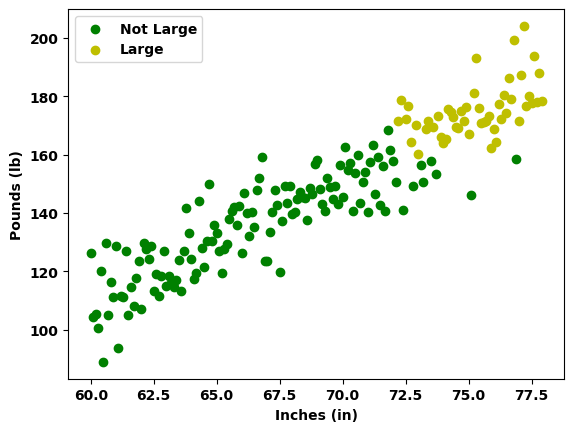

In [44]:
# Simulating categorized customer measurements
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

# Plots customer measurements while coloring the customers based on class.
# Customer heights and weights are treated as two different features in the feature matrix X.
# Customer class type is stored with the label array y.
def plot_customers(X, y, xlabel='Inches (in)', ylabel='Pounds (lb)'):
    colors = ['g', 'y']
    labels = ['Not Large', 'Large']
    for i, (color, label) in enumerate(zip(colors, labels)):
        plt.scatter(X[:,0][y == i], X[:,1][y == i], color=color, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

inches = np.arange(60, 78, 0.1)
# Note: Scale is the STD
random_fluctuations = np.random.normal(scale=10, size=inches.size)
pounds = 4 * inches - 130 + random_fluctuations

# FOllows the linear formula to model weight as a function of height
X = np.array([inches, pounds]).T

# Customers are considered Large if their height is greater than 72 inches and their weight is greater than 160 lbs
# Makes an array of 0s and 1s to represent when a customer is considered 'Large' under the conditions above
y = ((X[:,0] > 72) & (X[:,1] > 160)).astype(int)

plot_customers(X, y)
plt.legend()
plt.show()

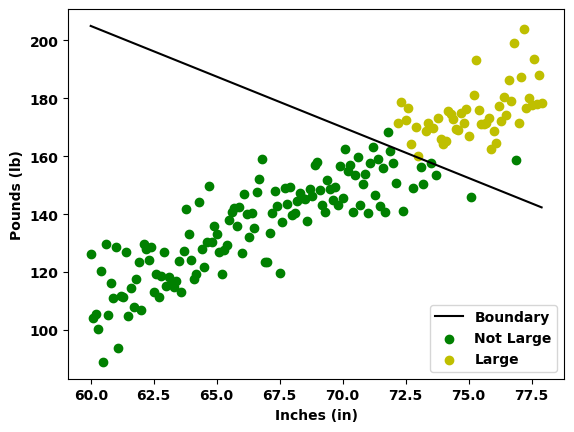

In [45]:
# Plotting a boundary to separate the two customer classes
def boundary(inches): return -3.5 * inches + 415
plt.plot(X[:,0], boundary(X[:,0]), color='k', label='Boundary')
plot_customers(X, y)
plt.legend()
plt.show()

The line above is a *linear decision boundary*  
**Linear Decision Boundary**: Can be used to accuratly destinguish between two classes

In [46]:
# Predicting classes using a linear boundary
from sklearn.metrics import f1_score
y_pred = []
for inches, lbs in X:
    # If b is a Python Boolean, int(b) returns 1 if the Boolean is True and 
    # 0 is the boolean is False. Hence, we can return the class label for 
    # measurements (inches, lbs) by running int(lbs > -3.5 * inches + 415)
    prediction = int(lbs > -3.5 * inches + 415)
    y_pred.append(prediction)

f_measure = f1_score(y_pred, y)
print(f'The f-measure is {f_measure:.2f}')

The f-measure is 0.97


A few notes on the inequality lbs > -3.5 * inches + lbs + 415
1. Inequality can become 3.5 * inches + lbs - 415 > 0  
2. Dot product of [x, y, z] @ [a, b, c] = x * a + y * b + z * c  
3. The dot product of [inches, lbs, 1] @ [3.1, 1, -415] = 3.5 * inches + lbs - 415  
4. Inequality now becomes w @ v > 0, with vectors w and v having the form of line 3  
  
Note: Only one of the w, v vectors os dependent on values of lbs and inches.  
The second vector, [3.5, 1, -415] does not vary with customer measurements. This is a *weight vector*  
**Weight Vector**: Invariant vector that is not dependent on input


In [47]:
# Predicting classes using vector dot products
weights = np.array([3.5, 1, -415])
predictions = [int(weights @ [inches, lbs, 1] > 0) for inches, lbs in X]
assert predictions == y_pred

**Padded Feature Matrix**: Making a new matrix, M, where each row is [inches, lbs, 1] rather than [inches, lbs] so we can just do the matrix-vector product M @ weights > 0, rather than creating a new vector, v, and runnning v @ weights > 0, recomputing v for every vector

In [48]:
# Predicting classes using matrix multiplication
M = np.column_stack([X, np.ones(X.shape[0])])
print("First five rows of our padded feature matrix are:")
print(np.round(M[:5], 2))

predictions = (M @ weights > 0)
assert predictions.tolist() == y_pred

First five rows of our padded feature matrix are:
[[ 60.   126.24   1.  ]
 [ 60.1  104.28   1.  ]
 [ 60.2  105.52   1.  ]
 [ 60.3  100.47   1.  ]
 [ 60.4  120.25   1.  ]]


**Linear Classifier**: Boiling down classification to a simple matrix-vector product. The only thing required is a weight vector

In [49]:
# Defining a linear classifier function
def linear_classifier(X, weights):
    M = np.column_stack([X, np.ones(X.shape[0])])
    return (M @ weights > 0).astype(int)

predictions = linear_classifier(X, weights)
assert predictions.tolist() == y_pred

**Bias**: The constant value stored in `weights[-1]`  
**Coefficients**: Remaining weights; During classification, each coefficient is multiplied against its corresponding feature

## 21.2 Training a Linear Classifier

In [50]:
# Classification using random weights
np.random.seed(0)
weights = np.random.normal(size=3)
y_pred = linear_classifier(X, weights)
f_measure = f1_score(y_pred, y)

print('We inputted the following random weights:')
print(np.round(weights, 2))
print(f'\nThe f-measure is {f_measure:.2f}')

We inputted the following random weights:
[1.76 0.4  0.98]

The f-measure is 0.43


In [51]:
# Outputtig the predicted classes
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [52]:
# Shifting the class predictions by lowering the weights
assert np.all(linear_classifier(X, [0, 0, 0]) == 0)

In [53]:
# Computing the bias shift based on prediction quality
def get_bias_shift(predicted, actual):
    if predicted == actual:
        return 0
    if predicted > actual:
        return 1
    
    return -1

In [54]:
# Computing the bias shift using arithmetic
for predicted, actual in [(0, 0), (1, 0), (0, 1), (1, 1)]:
    bias_shift = get_bias_shift(predicted, actual)
    assert bias_shift == predicted - actual

In [55]:
# Computing the bias shift with a learning rate
def get_bias_shift(predicted, actual, learning_rate=0.1):
    return learning_rate * (predicted - actual)

In [56]:
# Iteratively shifting the bias
def predict(v, weights): return int(v @ weights > 0)

starting_bias = weights[-1]
for i, actual in enumerate(y):
    predicted = predict(M[i], weights)
    bias_shift = get_bias_shift(predicted, actual)
    weights[-1] -= bias_shift

new_bias = weights[-1]
print(f"Our starting bias equaled {starting_bias:.2f}.")
print(f"The adjusted bias equals {new_bias:.2f}.")

Our starting bias equaled 0.98.
The adjusted bias equals -12.02.


In [57]:
# Checking performance after the bias shift
y_pred = linear_classifier(X, weights)
f_measure = f1_score(y_pred, y)
print(f'The f-measure is {f_measure:.2f}')

The f-measure is 0.43


In [58]:
# Computing all weight shifts in one line of code
old_weights = weights.copy()
for i, actual in enumerate(y):
    predicted = predict(M[i], weights)
    bias_shift = get_bias_shift(predicted, actual)
    weights -= bias_shift * M[i]

y_pred = linear_classifier(X, weights)
f_measure = f1_score(y_pred, y)

print("The weights previously equaled:")
print(np.round(old_weights, 2))
print("\nThe updated weights now equal:")
print(np.round(weights, 2))
print(f'\nThe f-measure is {f_measure:.2f}')

The weights previously equaled:
[  1.76   0.4  -12.02]

The updated weights now equal:
[ -4.64   2.22 -12.12]

The f-measure is 0.78


The f-measure after 1000 iterations is 0.62


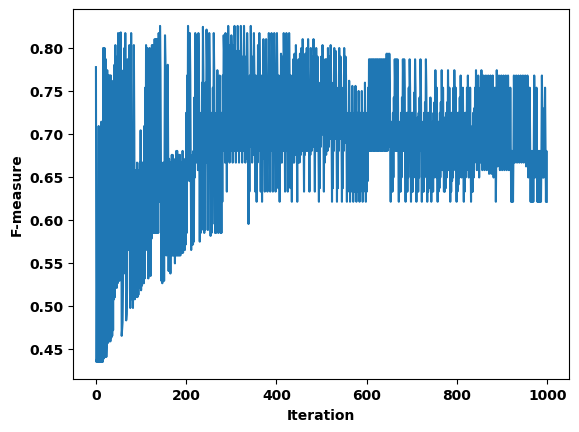

In [59]:
# Tweaking the weights over multiple iterations
np.random.seed(0)
weigths = np.random.normal(size=3)

f_measures = []
for _ in range(1000):
    y_pred = linear_classifier(X, weights)
    f_measures.append(f1_score(y_pred, y))
    for i, actual in enumerate(y):
        predicted = predict(M[i], weights)
        bias_shift = get_bias_shift(predicted, actual)
        weights -= bias_shift * M[i]

print(f'The f-measure after 1000 iterations is {f_measures[-1]:.2f}')
plt.plot(range(len(f_measures)), f_measures)
plt.xlabel('Iteration')
plt.ylabel('F-measure')
plt.show()

The f-measure after 1000 iterations is 0.82


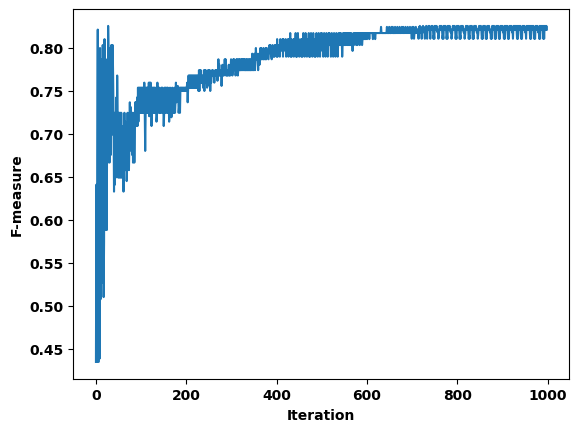

In [60]:
# Reducing weight shifts over miltiple iterations
np.random.seed(0)
# Trains a linear model from features X and labels y
# The predict function drives the weight shift by allowing us to compare predicted and actual class outpts.
# Later in this section we modify predit to add nuance to the weight shifts
def train(X, y, predict=predict):
    M = np.column_stack([X, np.ones(X.shape[0])])

    # A model with N features has N + 1 total weights representing N coefficients and one bias
    weights = np.random.normal(size=X.shape[1] + 1)
    f_measures = []
    for k in range(1, 1000):
        y_pred = linear_classifier(X, weights)
        f_measures.append(f1_score(y_pred, y))

        for i, actual in enumerate(y):
            predicted = predict(M[i], weights)
            bias_shift = get_bias_shift(predicted, actual)
            # At each kth iteration, we dampen the weight shift by dividing by k. This reduces the weight-shift oscillations
            weights -= bias_shift * M[i] / k

        # Returns the pptimized weights along with tracked perfomrance across the 1,000 iterations
    return weights, f_measures

weights, f_measures = train(X, y)
print(f'The f-measure after 1000 iterations is {f_measures[-1]:.2f}')
plt.plot(range(len(f_measures)), f_measures)
plt.xlabel('Iteration')
plt.ylabel('F-measure')
plt.show()

**Preceptron Training Algorithm**: A simple linear classifier

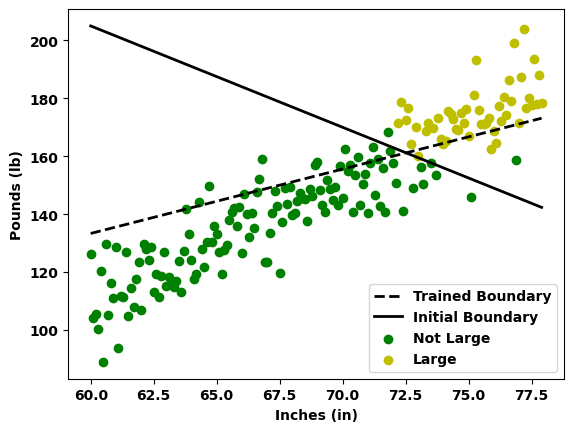

In [61]:
# Comparing the new and old decision boundaries
inches_coef, lbs_coef, bias = weights
def new_boundary(inches):
    return -(inches_coef * inches + bias) / lbs_coef

plt.plot(X[:,0], new_boundary(X[:,0]), color='k', linestyle='--', label='Trained Boundary', linewidth=2)
plt.plot(X[:,0], boundary(X[:,0]), color='k', label='Initial Boundary', linewidth=2)
plot_customers(X, y)
plt.legend()
plt.show()

Traind Boundary is shit compared to the one given earlier, but it is due to large X values, which can be minimized through *standardization*  
**Standardization**: X is adjusted to equal (X - X.mean(axis=0)) / X.std(axis=0)

### 21.2.1 Improving Preceptron Performance Through Standardization

In [62]:
# Printing feature eans and standard deviations
means = X.mean(axis=0)
stds = X.std(axis=0)
print(f"Mean values: {np.round(means, 2)}")
print(f"STD values: {np.round(stds, 2)}")

Mean values: [ 68.95 146.56]
STD values: [ 5.2  23.26]


**Standardization**: Standardize a feature matrix, X, by running (X - means) / stds

In [63]:
# Standardizing the feature matrix
def standardize(X):
    return (X - means) / stds

X_s = standardize(X)
assert np.allclose(X_s.mean(axis=0), 0)
assert np.allclose(X_s.std(axis=0), 1)

After standardization, the f-measure is 0.98


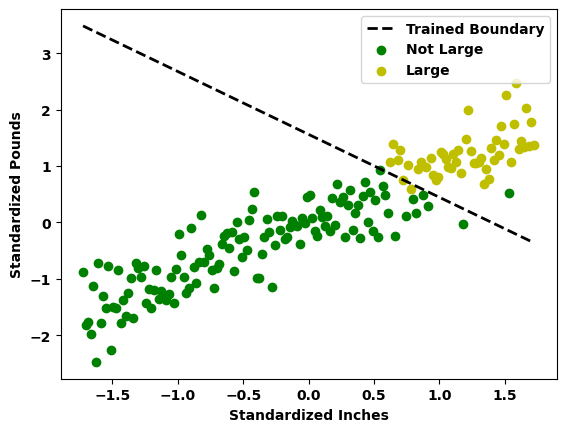

In [64]:
# Training on the standardized feature matrix
np.random.seed(0)
weights, f_measures = train(X_s, y)
print(f'After standardization, the f-measure is {f_measures[-1]:.2f}')

def plot_boundary(weights):
    a, b, c = weights
    new_boundary = lambda x: -(a * x + c) / b
    plt.plot(X_s[:,0], new_boundary(X_s[:,0]), color='k', linestyle='--', label='Trained Boundary', linewidth=2)
    plot_customers(X_s, y, xlabel='Standardized Inches', ylabel='Standardized Pounds')
    plt.legend()
    plt.plot()

plot_boundary(weights)

In [65]:
# Standardizing new classifier inputs
new_data = np.array([[63, 110], [76, 199]])
predictions = linear_classifier(standardize(new_data), weights)
print(predictions)

[0 1]


In [66]:
# Checking a perceptron's training consistency
np.random.seed(0)
poor_train_count = sum([train(X_s, y)[1][-1] < 0.97 for _ in range(5)])
print(f"The f-measure fell below our baseline of 0.97 in {poor_train_count} out of 5 training instances")

The f-measure fell below our baseline of 0.97 in 4 out of 5 training instances


## 21.3 Improving Linear Classification with Logistic Regression

**Directed Distance**: Unlike regular distance, this distance can be negative

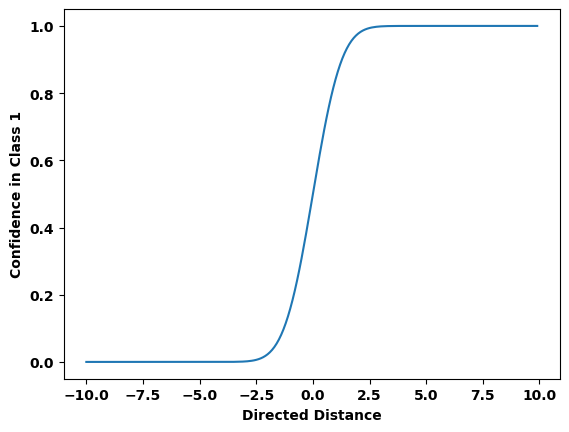

In [67]:
# Measuring uncertainty using stats.norm.cdf
from scipy import stats
z = np.arange(-10, 10, 0.1)
assert stats.norm.cdf(0.0) == 0.5
plt.plot(z, stats.norm.cdf(z))
plt.xlabel('Directed Distance')
plt.ylabel('Confidence in Class 1')
plt.show()

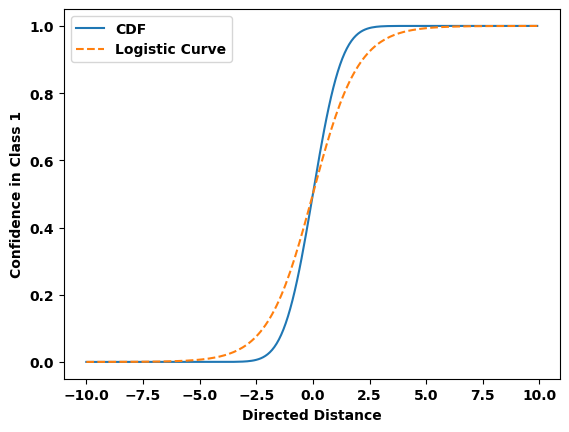

In [68]:
# Measurng uncertainty using the logistic curve
from math import e
plt.plot(z, stats.norm.cdf(z), label='CDF')
plt.plot(z, 1 / (1 + e ** -z), label='Logistic Curve', linestyle='--')
plt.xlabel('Directed Distance')
plt.ylabel('Confidence in Class 1')
plt.legend()
plt.show()

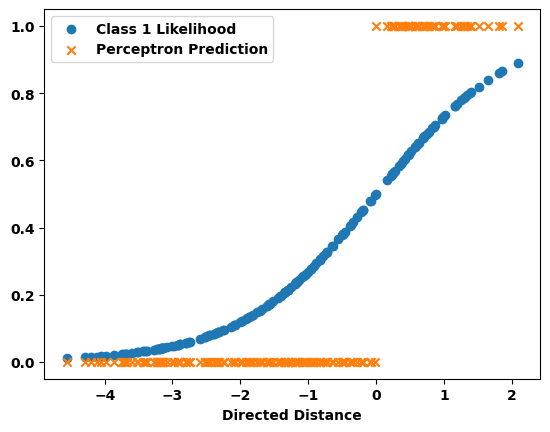

In [69]:
# Comparing logistic uncertainty to the perceptron's predictions
M = np.column_stack([X_s, np.ones(X_s.shape[0])])

# Directed distances to the boundary equals the product of the padded feature matrix and weights
distances = M @ weights
likelihoods = 1 / (1 + e ** -distances)
plt.scatter(distances, likelihoods, label='Class 1 Likelihood')
plt.scatter(distances, distances > 0, label='Perceptron Prediction', marker='x')
plt.xlabel('Directed Distance')
plt.legend()
plt.show()

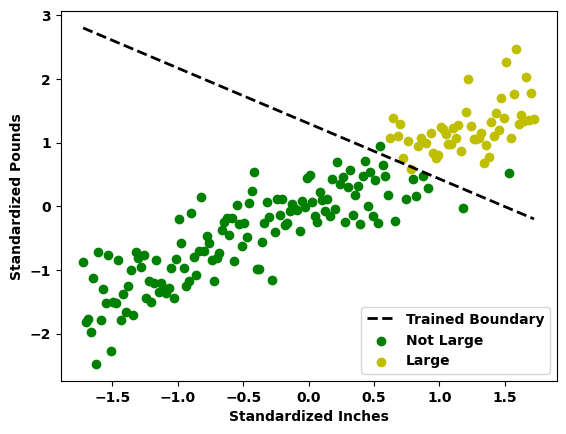

In [70]:
# Incorporating uncertainty into training
np.random.seed(0)
def logistic_predict(v, weights): return 1 / (1 + e ** -(weights @ v))
def train_logistic(X, y): return train(X, y, predict=logistic_predict)
logistic_weights = train_logistic(X_s, y)[0]
plot_boundary(logistic_weights)

In [71]:
# Checking the logistic model's training consistency
np.random.seed(0)
poor_train_count = sum([train_logistic(X_s, y)[1][-1] < 0.97 for _ in range(5)])
print(f"The f-measure fell below our baseline of 0.97 in {poor_train_count} out of 5 training instances")

The f-measure fell below our baseline of 0.97 in 0 out of 5 training instances


**Logistic Regression Classifier**: A better classifier than linear that is much more consistent and accurate

### 21.3.1 Running Logistic Regression on More than Two Features

In [72]:
# Training a three-feature logistic regression model
np.random.seed(0)
random_fluctuations = np.random.normal(size=X.shape[0], scale=0.1)

# Each waist measurement is 45% of a customer's height, with a random fluctuaction
waist = 0.45 * X[:,0] + random_fluctuations
X_w_waist = np.column_stack([X_s, (waist - waist.mean()) / waist.std()])
weights, f_measures = train_logistic(X_w_waist, y)

print("Our trained model has the following weights:")
print(np.round(weights, 2))
print(f"\nThe f-measure is {f_measures[-1]:.2f}")

Our trained model has the following weights:
[ 1.65  2.91  1.26 -4.08]

The f-measure is 0.97


## 21.4 Training Linear Classifiers using Scikit-Learn

In [73]:
# Importing scikit-learn's LogisticRegression class
from sklearn.linear_model import LogisticRegression

In [74]:
# Initializing a LogisticRegression classifier
clf = LogisticRegression()

In [75]:
# Training the classifier
clf.fit(X_s, y)

LogisticRegression()

The coefficients equal [[2.22 3.22]]
The bias equals [-3.96]


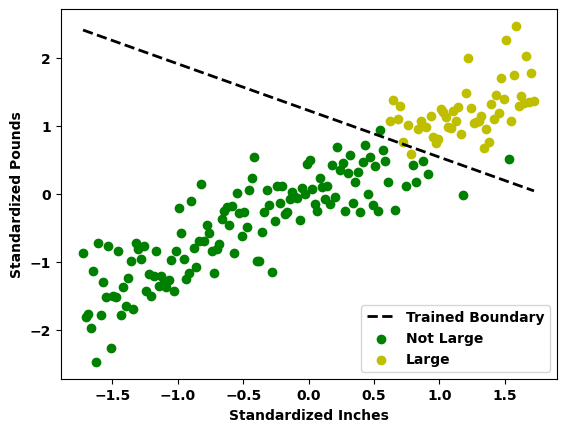

In [76]:
# Accessing the trained decision boundary
coefficients = clf.coef_
bias = clf.intercept_
print(f"The coefficients equal {np.round(coefficients, 2)}")
print(f"The bias equals {np.round(bias, 2)}")
plot_boundary(np.hstack([clf.coef_[0], clf.intercept_]))

In [77]:
# Predicting classes with the linear classifier
new_data = np.array([[63, 110], [76, 199]])
predictions = clf.predict(standardize(new_data))
print(predictions)

[0 1]


In [78]:
# Outputting the uncertainty associated with each class
probabilities = clf.predict_proba(standardize(new_data))
print(probabilities)

[[9.99990471e-01 9.52928118e-06]
 [1.80480919e-03 9.98195191e-01]]


In [79]:
# Initializing scikit-learn's standardization class
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

In [80]:
# Standardizing training data using scikit-learn
X_transformed = standard_scaler.fit_transform(X)
assert np.allclose(X_transformed.mean(axis=0), 0)
assert np.allclose(X_transformed.std(axis=0), 1)
assert np.allclose(X_transformed, X_s)

In [81]:
# Standardizing new data using scikit-learn
data_transformed = standard_scaler.transform(new_data)
assert np.array_equal(clf.predict(data_transformed), predictions)

### 21.4.1 Training Multiclass Linear Models

In [84]:
# Importing scikit-learn's wine dataset
from sklearn.datasets import load_wine
data = load_wine()
num_classes = len(data.target_names)
num_features = len(data.feature_names)
print(f"The wine dataset contains {num_classes} classes of wine:")
print(data.target_names)
print(f'\nIt contains the {num_features} features:')
print(data.feature_names)

The wine dataset contains 3 classes of wine:
['class_0' 'class_1' 'class_2']

It contains the 13 features:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [85]:
# Training a multiclass wine predictor
X, y = load_wine(return_X_y=True)
clf.fit(standard_scaler.fit_transform(X), y)
biases = clf.intercept_

print(f"We trained {biases.size} decision boundaries, corresponding to the {num_classes} classes of wine.\n")

for i, bias in enumerate(biases):
    label = data.target_names[i]
    print(f"The {label} decision boundary has a bias of {bias:0.2f}")

We trained 3 decision boundaries, corresponding to the 3 classes of wine.

The class_0 decision boundary has a bias of 0.41
The class_1 decision boundary has a bias of 0.70
The class_2 decision boundary has a bias of -1.12


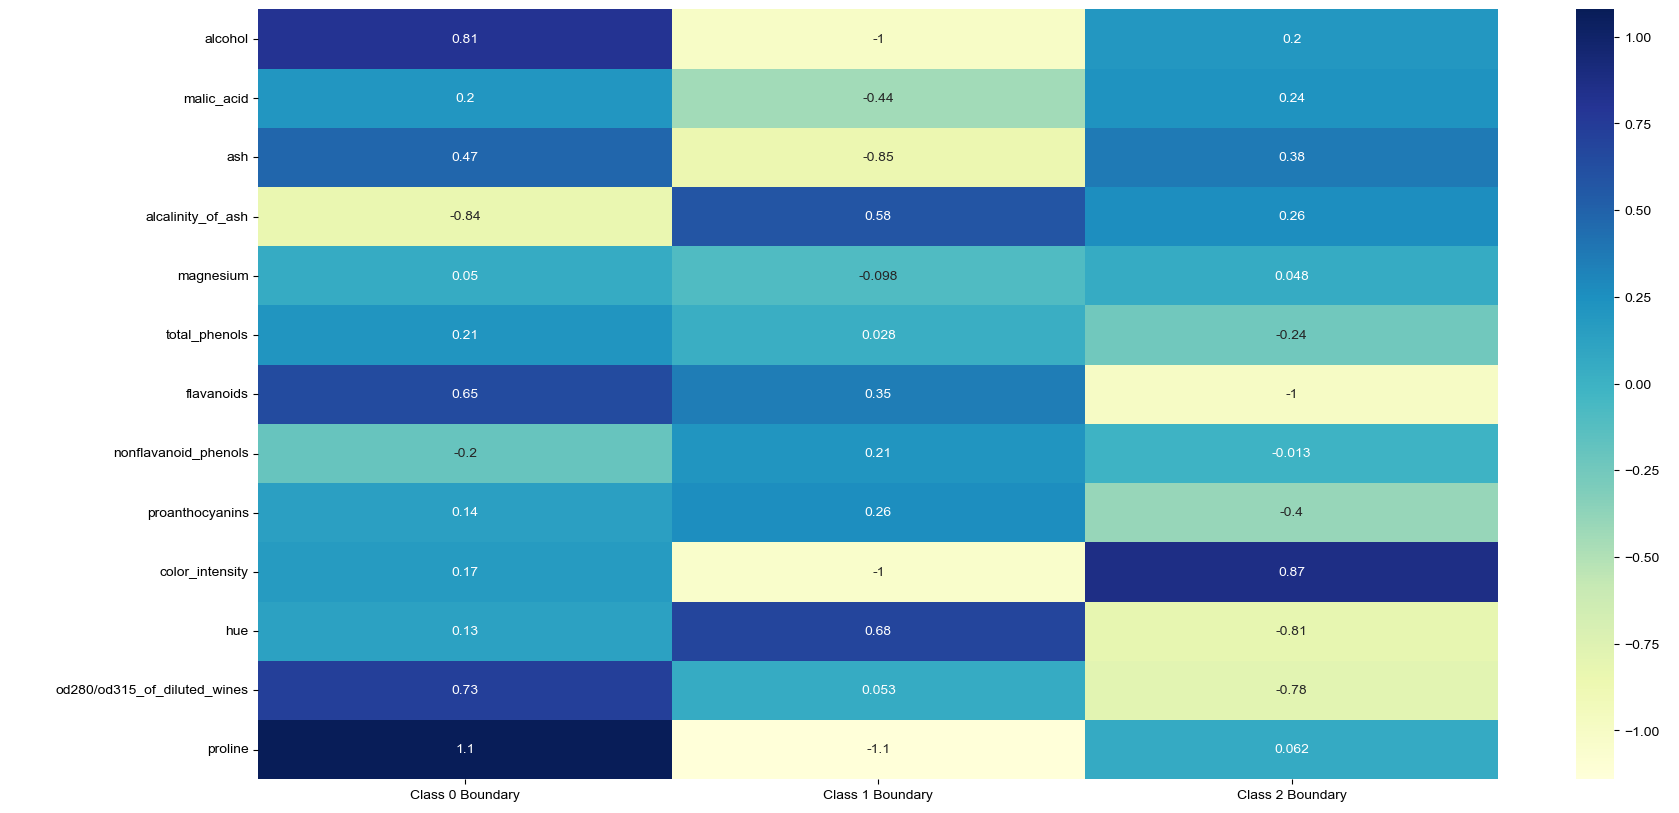

In [86]:
# Displaying  a transpose of the coefficient matrix
import seaborn as sns
plt.figure(figsize=(20, 10))
coefficients = clf.coef_

sns.heatmap(coefficients.T, cmap='YlGnBu', annot=True, xticklabels=[f"Class {i} Boundary" for i in range(3)], yticklabels=data.feature_names)
plt.yticks(rotation=0)
sns.set(font_scale=2)
plt.show()

## 21.5 Measuring Feature Importance with Coefficients

**Feature Importance**: A score that ranks the usefulness of features during classification; in linear classifiers, the absolute values of the coefficients serve as crude measures of importance

In [88]:
# Ranking class 0 features by importance
# Ranks the features based on the absolute value of the coefficients in clf.coef_[class_label]
def rank_features(class_label):
    absolute_values = np.abs(clf.coef_[class_label])

    # Sorts feature indices by absolute values in descending order
    for i in np.argsort(absolute_values)[::-1]:
        name = data.feature_names[i]
        coef = clf.coef_[class_label][i]
        print(f"{name}: {coef:.2f}")

rank_features(0)

proline: 1.08
alcalinity_of_ash: -0.84
alcohol: 0.81
od280/od315_of_diluted_wines: 0.73
flavanoids: 0.65
ash: 0.47
total_phenols: 0.21
malic_acid: 0.20
nonflavanoid_phenols: -0.20
color_intensity: 0.17
proanthocyanins: 0.14
hue: 0.13
magnesium: 0.05


In [89]:
# Ranking Class 1 features by importance
rank_features(1)

proline: -1.14
color_intensity: -1.04
alcohol: -1.01
ash: -0.85
hue: 0.68
alcalinity_of_ash: 0.58
malic_acid: -0.44
flavanoids: 0.35
proanthocyanins: 0.26
nonflavanoid_phenols: 0.21
magnesium: -0.10
od280/od315_of_diluted_wines: 0.05
total_phenols: 0.03


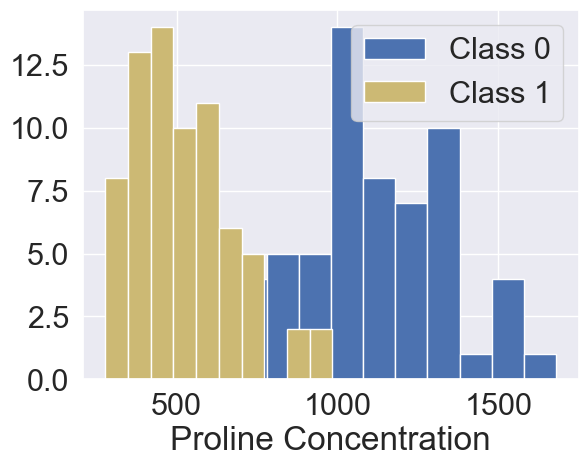

In [90]:
# Plotting proline histograms across Classes 0 and 1 wines
index = data.feature_names.index('proline')
plt.hist(X[y == 0][:, index], label='Class 0')
plt.hist(X[y == 1][:, index], label='Class 1', color='y')
plt.xlabel('Proline Concentration')
plt.legend()
plt.show()

## 21.6 Linear Classifier Limitations

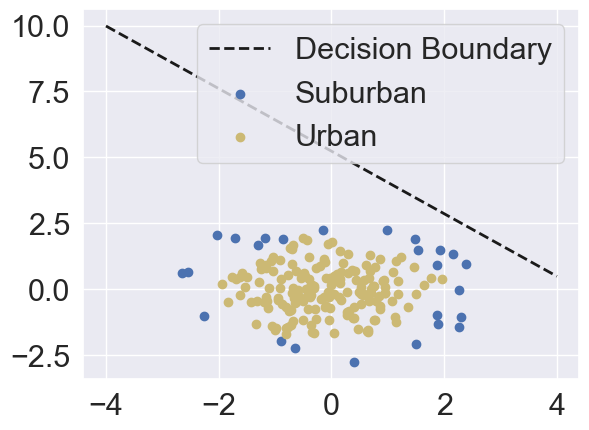

In [92]:
# Simulating a nonlinearly separable scenario
np.random.seed(0)
X = np.array([[np.random.normal(), np.random.normal()] for _ in range(200)])
y = (np.linalg.norm(X, axis=1) < 2).astype(int)

clf = LogisticRegression()
clf.fit(X, y)
weights = np.hstack([clf.coef_[0], clf.intercept_])

a, b, c = weights
boundary = lambda x: -(a * x + c) / b
plt.plot(range(-4, 5), boundary(range(-4, 5)), color='k', linestyle='--', linewidth=2, label='Decision Boundary')

for i in [0, 1]:
    plt.scatter(X[y == i][:, 0], X[y == i][:, 1], label=['Suburban', 'Urban'][i], color=['b', 'y'][i])

plt.legend()
plt.show()

# Key Words / Notes: